In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [166]:
years = np.arange(2015, 2026)
dfs = []
for year in years:
    df = pd.read_csv(f'data/rosters.nosync/rosters_{year}.csv')
    df['Year'] = year
    dfs.append(df)
stats = pd.concat(dfs).reset_index(drop = True)
stats['Date'] = stats['game_id'].str[:-4].apply(lambda x: datetime.strptime(x, '%Y%m%d'))
stats = stats[['game_id', 'Date', 'Year', 'player_id', 'Player', 'Team', 'MP', 'VORP']]

In [167]:
season_start = stats.groupby('Year')['Date'].min().to_dict()
season_end = stats.groupby('Year')['Date'].max().to_dict()

In [168]:
# dates = np.arange(st, en + timedelta(days = 1), timedelta(days = 1))

In [169]:
# stats_yr = stats[stats['Year'] == 2015]

In [170]:
# stats[['game_id', 'Date', 'Year', 'player_id', 'Player', 'Team', 'VORP', 'E', 'S', 'k', 'R', 'R_new']]

In [171]:
BETA = 0.1
R_0 = 100

(array([ 6566., 27727., 48995., 57149., 41878., 30201., 22110., 17482.,
        11993.,  6121.]),
 array([0.01477403, 0.11325248, 0.21173093, 0.31020939, 0.40868784,
        0.50716629, 0.60564474, 0.70412319, 0.80260164, 0.9010801 ,
        0.99955855]),
 <BarContainer object of 10 artists>)

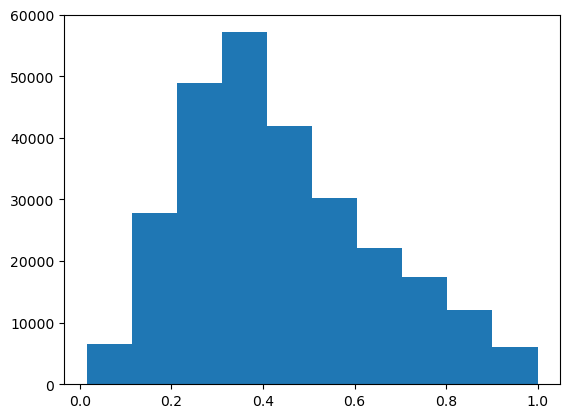

In [176]:
# stats = pd.read_csv(f'stats/rosters.nosync/rosters_2025.csv')
stats['S'] = 1 / (1 + np.exp(0.5 - 0.25 * stats['VORP']))
plt.hist(stats['S'])

In [177]:
game_ids = sorted(stats['game_id'].unique())

In [178]:
def process_game(game):

    game_id = game['game_id'].values[0]

    home = game[
        game['Team'].apply(lambda x: x in game_id)
    ].sort_values('player_id').reset_index(drop = True).copy()
    away = game[
        ~game['Team'].apply(lambda x: x in game_id)
    ].sort_values('player_id').reset_index(drop = True).copy()

    mp_total = home['MP'].sum()

    E_home = [
        sum(
            [
                (mp / mp_total) / (1 + 10 ** ((r_away - r_home) / 400)) 
                for r_away, mp in zip(away['R'], away['MP'])
            ]
        )
        for r_home in home['R']
    ]
    home['E'] = E_home

    E_away = [
        sum(
            [
                (mp / mp_total) / (1 + 10 ** ((r_home - r_away) / 400)) 
                for r_home, mp in zip(home['R'], home['MP'])
            ]
        )
        for r_away in away['R']
    ]
    away['E'] = E_away

    k_home = np.clip(35/48 * home['MP'] + 5, 5, 40)
    k_away = np.clip(35/48 * away['MP'] + 5, 5, 40)
    home['k'] = k_home
    away['k'] = k_away

    R_new_home = home['R'] + k_home * (home['S'] - E_home)
    R_new_away = away['R'] + k_away * (away['S'] - E_away)
    home['R_new'] = R_new_home
    away['R_new'] = R_new_away


    return pd.concat([home, away]).reset_index(drop = True)


def update_elo(elo, processed_game):
    updated_elo = dict(zip(processed_game['player_id'], processed_game['R_new']))
    return elo | updated_elo

In [179]:
elo = {}
processed_games = []

for i, game_id in enumerate(game_ids):

    # Filter game
    game = stats[
        stats['game_id'] == game_id
    ].copy()

    # Map players elo
    for player in game['player_id']:
        if player not in elo.keys():
            elo[player] = R_0
    game['R'] = game['player_id'].map(elo)

    processed_game = process_game(game)
    elo = update_elo(elo, processed_game)
    processed_games.append(processed_game)

In [180]:
history = pd.concat(processed_games).sort_values('game_id').reset_index(drop = True)

In [181]:
history['R_diff'] = history['R_new'] - history['R']
history['gain'] = history['R_new'] - history['k'] * (history['S'] - history['E'])

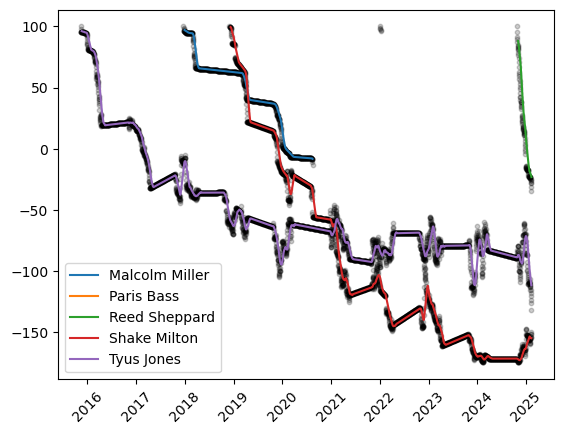

In [190]:

for _ in range(5): 

    random_player = history[['Player', 'player_id']].drop_duplicates().sample(1)
    random_player_id = random_player['player_id'].values[0]
    hist = history[history['player_id'] == random_player_id]

    time = pd.DataFrame(np.arange(hist['Date'].min(), hist['Date'].max() + timedelta(days=1), timedelta(days=1)), columns = ['Date'])
    time = time.merge(hist, how = 'left', on = 'Date')
    time['R_inf'] = time['R'].interpolate(method = 'linear')
    plt.scatter(time['Date'], time['R_inf'], s = 10, c = 'k', alpha = 0.2)
    plt.plot(time['Date'], time['R_inf'].rolling(30, min_periods = 10).mean(), label = random_player['Player'].values[0])
plt.legend()
plt.xticks(rotation = 45)
plt.show()

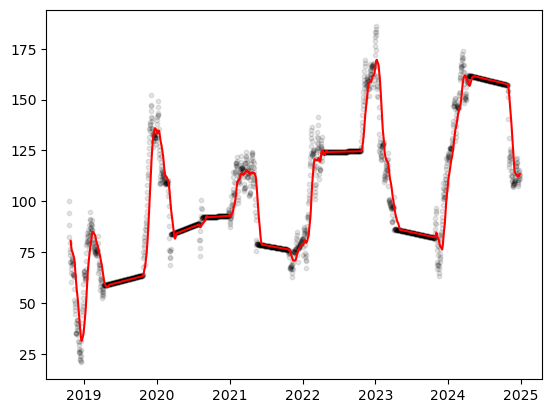

In [202]:
random_player = history[['Player', 'player_id']].drop_duplicates().sample(1)
random_player_id = random_player['player_id'].values[0]
hist = history[history['player_id'] == 'doncilu01']

time = pd.DataFrame(np.arange(hist['Date'].min(), hist['Date'].max() + timedelta(days=1), timedelta(days=1)), columns = ['Date'])
time = time.merge(hist, how = 'left', on = 'Date')
time['R_inf'] = time['R'].interpolate(method = 'linear')
plt.scatter(time['Date'], time['R_inf'], s = 10, c = 'k', alpha = 0.1)
plt.plot(time['Date'], time['R_inf'].rolling(30, min_periods = 10).mean(), label = random_player['Player'].values[0], c = 'red')

In [200]:
pd.DataFrame(elo.items(), columns = ['pid', 'elo']).sort_values('elo')

,pid,elo
386,smithis01,-219.863942
1250,mathube01,-207.556086
1359,micicva01,-206.523638
1134,mitchda01,-204.399181
1294,branhma01,-203.262466
...,...,...
133,shvedal01,101.359568
171,boshch01,101.648168
819,doncilu01,109.211934
807,gilgesh01,139.236542


In [123]:
time = pd.DataFrame(np.arange(hist['Date'].min(), hist['Date'].max() + timedelta(days=1), timedelta(days=1)), columns = ['Date'])

In [124]:
time = time.merge(hist, how = 'left', on = 'Date')

In [125]:
time['R_inf'] = time['R'].interpolate(method = 'linear')

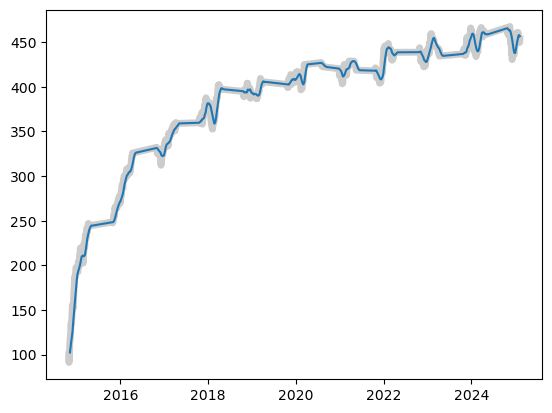

In [131]:
plt.plot(time['Date'], time['R_inf'], lw = 5, c = 'k', alpha = 0.2)
plt.plot(time['Date'], time['R_inf'].rolling(30, min_periods = 10).mean())

In [366]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [33]:
features = ['TRB', 'AST', 'PTS', 'GmSc', '+/-', 'eFG%', 'VORP']

In [19]:
model = LogisticRegression()

In [20]:
model.fit(stats[cols], stats['y'])

LogisticRegression()

In [21]:
model.coef_

array([[ 5.47375767e-03,  2.64623501e-02, -4.73339575e-02,
         2.12785281e-01, -5.43626667e-04,  1.33828261e+00,
         9.13909040e+00]])

In [45]:
stats = stats[
    stats['MP'] >= 5
]

In [58]:
quartiles = range(1, 100)

In [ ]:
dummy_dict = {
    f: [
        np.percentile(stats[f], q)
        for q in quartiles
    ]
    for f in features
}

In [65]:
dummy_df = pd.DataFrame(dummy_dict)
dummy_df['S'] = np.array(quartiles) / 100

In [72]:
coefs = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
beta = 0.1

In [100]:
model = LinearRegression()
model.fit(dummy_df[['PTS', 'GmSc', 'VORP']], dummy_df['S'])
model.coef_, model.intercept_

(array([-0.06085282,  0.1079416 , -0.00441663]), 0.19482880805451852)

In [84]:
features

['TRB', 'AST', 'PTS', 'GmSc', '+/-', 'eFG%', 'VORP']

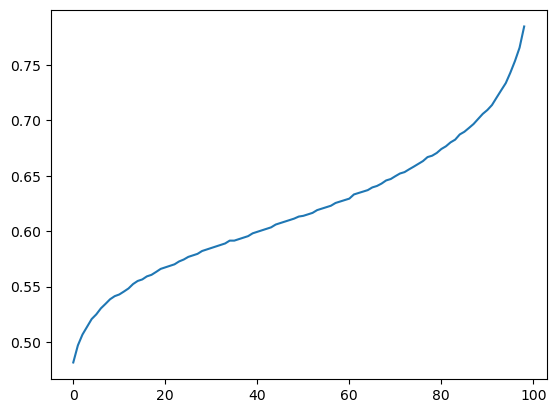

In [97]:
coefs = np.array([0.005, 0.056])
beta = 0.38
plt.plot(1 / (1 + np.exp(-(dummy_df[['PTS', 'VORP']].to_numpy() @ coefs + beta))))

<Axes: >

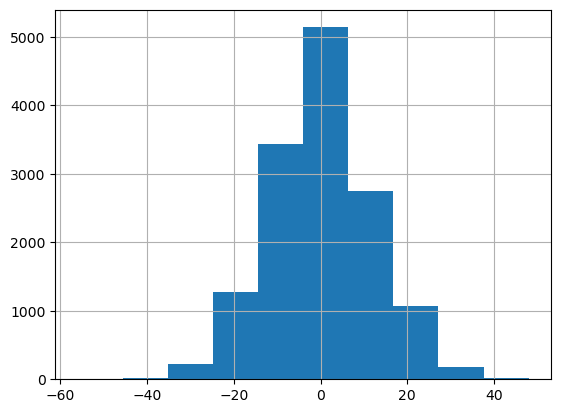

In [86]:
stats['+/-'].hist()

In [104]:
stats.sort_values('VORP', ascending = True).head()

,game_id,Player,player_id,Team,MP,FG,FGA,FG%,3P,3PA,...,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM,VORP,starter,y
10726,202501020OKC,Norman Powell,powelno01,LAC,27.583333,1,11,0.091,0,5,...,0.0,0.0,31.3,30.8,41.0,123.0,-27.6,-14.7,True,0
12070,202501110DET,RJ Barrett,barrerj01,TOR,32.783333,4,16,0.250,0,8,...,2.9,0.0,21.2,29.9,55.0,122.0,-20.7,-12.8,True,0
13649,202501250ATL,Trae Young,youngtr01,ATL,38.150000,5,12,0.417,1,4,...,0.0,0.0,41.5,28.0,64.0,115.0,-17.8,-12.6,True,0
3113,202411100DET,Jaden Ivey,iveyja01,DET,34.166667,4,15,0.267,0,4,...,0.0,0.0,28.6,26.3,47.0,107.0,-19.4,-12.4,True,0
11559,202501070WAS,Alex Sarr,sarral01,WAS,23.300000,1,12,0.083,0,5,...,2.1,3.5,20.0,26.7,31.0,129.0,-27.1,-12.2,True,0


In [166]:
metrics = ['PTS', 'AST', 'TRB', 'VORP']
beta = np.array([0.025, 0.01, 0.005, .5])
beta_0 = -1

dummy_dict = {
    col: [
        np.percentile(stats[col], q)
        for q in quartiles
    ]
    for col in metrics
}

dummy_df = pd.DataFrame(dummy_dict)
dummy_df['S'] = np.array(quartiles) / 100

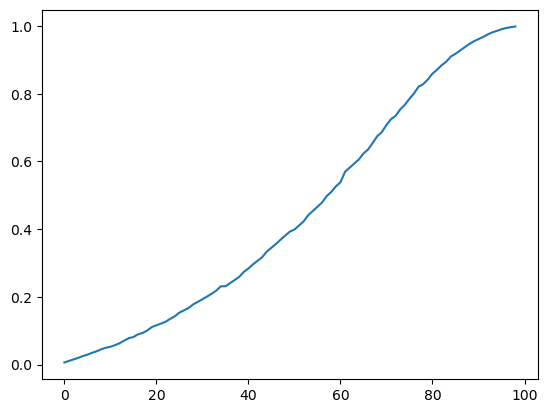

In [167]:
plt.plot(1 / (1 + np.exp(-(dummy_df[metrics].to_numpy() @ beta + beta_0))))

In [168]:
dummy_df['S_pred'] = 1 / (1 + np.exp(-(dummy_df[metrics].to_numpy() @ beta + beta_0)))

In [127]:
np.percentile(stats['PTS'], 0)

0.0

In [129]:
dummy_df

,PTS,AST,TRB,VORP,S,S_pred
0,-8.100,-8.100,-8.100,-8.100,0.01,0.010750
1,-7.000,-7.000,-7.000,-7.000,0.02,0.021041
2,-6.300,-6.300,-6.300,-6.300,0.03,0.032108
3,-5.800,-5.800,-5.800,-5.800,0.04,0.043273
4,-5.300,-5.300,-5.300,-5.300,0.05,0.058085
...,...,...,...,...,...,...
94,8.800,8.800,8.800,8.800,0.95,0.997416
95,9.496,9.496,9.496,9.496,0.96,0.998320
96,10.400,10.400,10.400,10.400,0.97,0.999040
97,11.400,11.400,11.400,11.400,0.98,0.999484


In [175]:
stats['S'] = 1 / (1 + np.exp(-(stats[metrics].to_numpy() @ beta + beta_0)))

/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_9004/480084779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['S'] = 1 / (1 + np.exp(-(stats[metrics].to_numpy() @ beta + beta_0)))


In [180]:
stats[['Player', 'MP'] + metrics + ['S']].sort_values('S', ascending = True).tail(20)

,Player,MP,PTS,AST,TRB,VORP,S
4105,De'Aaron Fox,44.483333,60,7,3,17.6,0.999916
942,Paolo Banchero,39.616667,50,9,13,18.0,0.999918
11107,Nikola Jokić,43.316667,46,10,9,18.3,0.999921
5691,Damian Lillard,37.900000,37,12,3,18.8,0.999922
10662,Tyrese Haliburton,34.683333,33,15,5,19.2,0.999932
8863,Bobby Portis,31.733333,34,8,10,19.3,0.999934
9441,Mikal Bridges,43.250000,41,4,1,19.4,0.999943
14910,Trey Murphy III,37.866667,41,3,3,19.6,0.999948
12947,Daniel Gafford,33.633333,31,3,15,20.3,0.999956
14598,Nikola Jokić,36.550000,28,17,13,20.2,0.999956


<Axes: >

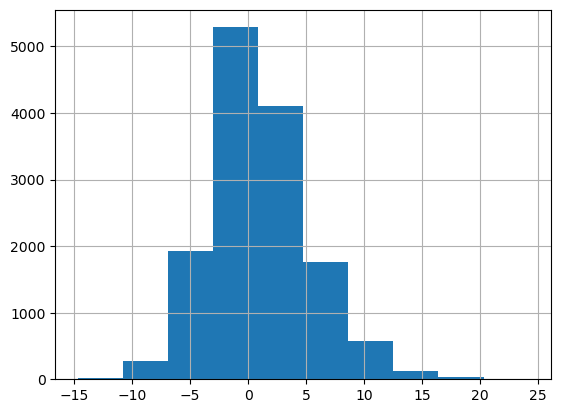

In [181]:
stats['VORP'].hist()